In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
import itertools
import matplotlib.patches as mpatches

# 0. Load loaction and grouppings information

In [4]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_153_samples_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['Sample_ID', 'country', 'year', 'post_dupe_depth']]
INFO.rename(columns={'Sample_ID':'sample', 
                     'country':'country', 
                     'year':'year', 
                     'post_dupe_depth':'depth'}, inplace=True)

In [5]:
countries_order = ['Indonesia', 'Solomon_Islands', 'Malaysia', 'Papua_New_Guinea', 'Mexico', 'Virgin_Islands',
                   'French_Guiana', 'Suriname', 'Costa_Rica', 'Ghana', 'Gabon', 'South_Africa', 'Florida']

In [6]:
## Read samples grouppings info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'groupings_v3.tsv'
file_data = glob(dir_path + file_name)[0]
GROUPS = pd.read_csv(file_data, sep='\t')

INFO = pd.merge(INFO, GROUPS, on='country')

## 1. What fraction of CDS is also GERP high score bases?

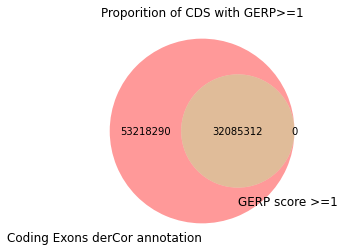

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Sizes for each group and their overlap
size_A = 85303602-32085312
size_B = 0
overlap_AB = 32085312

# Create a Venn diagram
venn_diagram = venn2(subsets=(size_A, size_B, overlap_AB), 
                     set_labels=('Coding Exons derCor annotation', 'GERP score >=1'))

# Display the Venn diagram
plt.title("Proporition of CDS with GERP>=1")
plt.show()

## 2. GERP and snpEff overlap. Sanity check

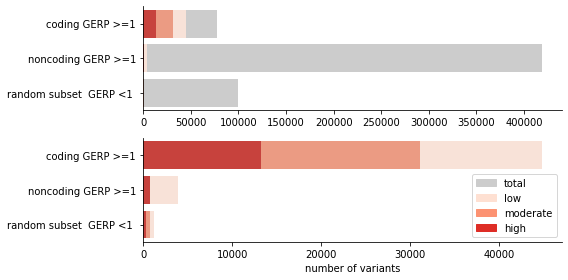

In [32]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/GERP/'
file_name = 'gerp_vs_snpeff.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## calculate fractions
df['high_f'] = df['high'] / df['total']
df['total_f'] = df['total'] / df['total']

df['h+m'] = df['high'] + df['moderate']
df['h+m+l'] = df['h+m'] + df['low']
df['h+m_f'] = df['h+m'] / df['total']
df['h+m+l_f'] = df['h+m+l'] / df['total']

p = ['#cccccc', '#fee0d2', '#fc9272', '#de2d26']
fig, axes = plt.subplots(2, 1, figsize = (8, 4))
ax1, ax2 = axes[0], axes[1]

## Plot total numbers
values_total = ['total', 'h+m+l', 'h+m', 'high']
values_fraction = ['h+m+l', 'h+m', 'high']
labels = ['total', 'low', 'moderate', 'high']
patch_colors = []

for i in range(len(values_total)):
    v1 = values_total[i]
    c = p[i]
    l = labels[i]
    patch_colors.append(mpatches.Patch(color=c, label=l))
    sns.barplot(ax=ax1, data=df, y='category', x=v1, color=c)
    if i != 0:
        v2 = values_fraction[i - 1]
        sns.barplot(ax=ax2, data=df, y='category', x=v2, color=c)

# ax1.set_xlim(0, 150000)
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('')
ax2.set_xlabel('number of variants')
    
# add custom legend
plt.legend(handles=patch_colors)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()


## 3. Variants by state

In [7]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'GERP/all_samples.gerp.derCor_153.by_state_var.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all.head(3)

,sample,variant,number,state,impact,country,year,depth,grouping
0,dc_37417_bb_noq,snps,2967,hom,coding,Indonesia,2006,17.91,during decline
1,dc_37417_bb_noq,snps,5890,het,coding,Indonesia,2006,17.91,during decline
2,dc_37417_bb_noq,indels,2223,hom,coding,Indonesia,2006,17.91,during decline


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


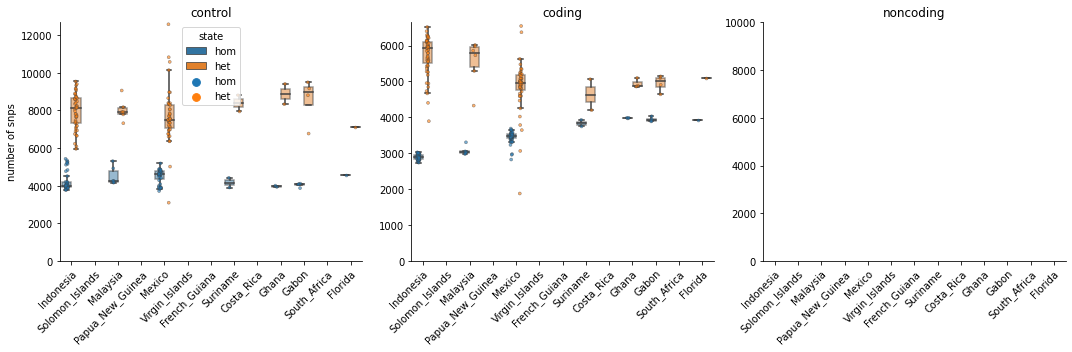

In [8]:
impacts = list(set(df['impact']))
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

variant = 'snps'
for i in range(len(impacts)):
    axi = axes[i]
    impact = impacts[i]
#     dfi = df_all[df_all['impact'] == impact]
    dfi = df_all[(df_all['variant'] ==  variant) & (df_all['impact'] ==  impact)]
    dfi = dfi[dfi['number'] != 0]
    
    sns.boxplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                showfliers=False, boxprops=dict(alpha=0.5))
    sns.stripplot(ax=axi, data=dfi, x='country', y='number', hue='state', order=countries_order, 
                  alpha=0.6, s=3, dodge=True, linewidth=0.5)
    
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axi.set_title('{}'.format(impact))
    axi.set_xlabel('')
    axi.set_ylim(0, max(dfi['number']) + 100)
    if i == 0:
        axi.set_ylabel('number of snps')
    else:
        axi.set_ylabel('')
        axi.get_legend().set_visible(False)

axes[2].set_ylim(0, 10000)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()